In [1]:
import pandas as pd
from functions import extract_patch_by_location
import os

In [2]:
import re
import warnings
import shapely
import pandas as pd
import geopandas as gpd
import yaml

from typing import Union, Tuple
from pathlib import Path
from multiprocessing import Pool, cpu_count


class GSONTile:
    def __init__(
        self,
        fname: Union[Path, str],
        xmin: int = None,
        ymin: int = None,
        tile_size: int = (1000, 1000),
    ) -> None:
        """Class abstaraction for one tile of geojson annotations.

        Parameters
        ----------
            fname : Path or str
                Name of the gson file.
            xmin : int, default=None
                The min-x coordinate of the tile.
            ymin : int, default=None
                The min-y coordinate of the tile.
            tile_size : Tuple[int, int], default=(1000, 1000))
                Size of the input tile.
        """
        assert Path(fname).exists(), f"File {fname} not found."
        assert Path(fname).suffix in (
            ".json",
            ".geojson",
        ), f"Input File {fname} has wrong format. Expected '.json'."

        self.fname = Path(fname)

        if None in (xmin, ymin):
            xmin, ymin = self._get_xy_coords(self.fname)

        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmin + tile_size[0]
        self.ymax = ymin + tile_size[1]

    def __len__(self):
        df = pd.read_json(self.fname)
        length = len(df)

        # empty mem
        del df

        return length

    def __set_value(
        self, anns1: gpd.GeoDataFrame, anns2: gpd.GeoDataFrame
    ) -> gpd.GeoDataFrame:
        """Catch annoying future warning to not flood stdout."""
        with warnings.catch_warnings():
            # Setting values in-place is fine, ignore the warning in Pandas >= 1.5.0
            # This can be removed, if Pandas 1.5.0 does not need to be supported any
            # longer. See also: https://stackoverflow.com/q/74057367/859591
            warnings.filterwarnings(
                "ignore",
                category=FutureWarning,
                message=(
                    ".*will attempt to set the values inplace instead of always setting a new array. "
                    "To retain the old behavior, use either.*"
                ),
            )
            anns1.loc[:, "geometry"] = anns2

        return anns1

    def _get_xy_coords(self, fname: str) -> Tuple[int, int]:
        """fname needs to contain x & y-coordinates in "x-[coord1]_y-[coord2]"-format"""
        if isinstance(fname, Path):
            fname = fname.as_posix()

        assert re.findall(
            r"(x-\d+_y-\d+)", fname
        ), "fname not in 'x-[coord1]_y-[coord2]'-format"
        xy_str = re.findall(r"(x-\d+_y-\d+)", fname)
        x, y = (int(c) for c in re.findall(r"\d+", xy_str[0]))

        return x, y

    @property
    def gdf(self) -> gpd.GeoDataFrame:
        """Read a geojson/json file and convert it to geopandas df

        NOTE: Adds bounding box-coords for the polygons.
        """
        # try:
        df = pd.read_json(self.fname)

        if df.empty:
            warnings.warn(
                f"No annotations detected in {self.fname.name}. Returning None.",
                RuntimeWarning,
            )

            return None

        df["geometry"] = df["geometry"].apply(shapely.geometry.shape)
        gdf = gpd.GeoDataFrame(df).set_geometry("geometry")

        # drop invalid geometries if there are any after buffer
        #gdf.geometry = gdf.geometry.buffer(0)
        #gdf = gdf[gdf.is_valid]

        # drop empty geometries
        #gdf = gdf[~gdf.is_empty]

        # drop geometries that are not polygons
        #gdf = gdf[gdf.geom_type == "Polygon"]

        try:
            # add bounding box coords of the polygons to the gdfs
            # and correct for the max coords
            gdf["xmin"] = gdf.bounds["minx"].astype(int)
            gdf["ymin"] = gdf.bounds["miny"].astype(int)
            gdf["ymax"] = gdf.bounds["maxy"].astype(int) + 1
            gdf["xmax"] = gdf.bounds["maxx"].astype(int) + 1
        except Exception:
            warnings.warn(
                f"Could not create bounds cols to {self.fname.name} gdf", RuntimeWarning
            )

        try:
            # add class name column
            gdf["class_name"] = gdf["properties"].apply(
                lambda x: x["classification"]["name"]
            )
        except Exception:
            warnings.warn(
                f"Could not create 'class_name' col for {self.fname.name} gdf.",
                RuntimeWarning,
            )

        return gdf
    
    @property
    def gdf_patch(self) -> gpd.GeoDataFrame:
        """Read a geojson/json file and convert it to geopandas df

        NOTE: Adds bounding box-coords for the polygons.
        """
        # try:
        df = pd.read_json(self.fname)

        if df.empty:
            warnings.warn(
                f"No annotations detected in {self.fname.name}. Returning None.",
                RuntimeWarning,
            )

            return None
        df['geometry']=df['features'].apply(lambda x: x['geometry'])
        df["geometry"] = df["geometry"].apply(shapely.geometry.shape)
        gdf = gpd.GeoDataFrame(df).set_geometry("geometry")

        # drop invalid geometries if there are any after buffer
        #gdf.geometry = gdf.geometry.buffer(0)
        #gdf = gdf[gdf.is_valid]

        # drop empty geometries
        #gdf = gdf[~gdf.is_empty]

        # drop geometries that are not polygons
        #gdf = gdf[gdf.geom_type == "Polygon"]

        try:
            # add bounding box coords of the polygons to the gdfs
            # and correct for the max coords
            gdf["xmin"] = gdf.bounds["minx"].astype(int)
            gdf["ymin"] = gdf.bounds["miny"].astype(int)
            gdf["ymax"] = gdf.bounds["maxy"].astype(int) + 1
            gdf["xmax"] = gdf.bounds["maxx"].astype(int) + 1
        except Exception:
            warnings.warn(
                f"Could not create bounds cols to {self.fname.name} gdf", RuntimeWarning
            )

        try:
            # add class name column
            gdf["class_name"] = gdf["properties"].apply(
                lambda x: x["classification"]["name"]
            )
        except Exception:
            warnings.warn(
                f"Could not create 'class_name' col for {self.fname.name} gdf.",
                RuntimeWarning,
            )

        return gdf

    @property
    def non_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that do not touch any edges of the tile."""
        not_r = self.gdf["xmax"] != self.xmax
        not_l = self.gdf["xmin"] != self.xmin
        not_b = self.gdf["ymax"] != self.ymax
        not_t = self.gdf["ymin"] != self.ymin
        non_border_annots = self.gdf[not_r & not_l & not_b & not_t].copy()
        # non_border_annots.loc[:, "geometry"] = non_border_annots
        non_border_annots = self.__set_value(non_border_annots, non_border_annots)
        non_border_annots = non_border_annots.reset_index(drop=True)
        return non_border_annots

    @property
    def right_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the right edge of the tile."""
        r_border_anns = self.gdf[self.gdf["xmax"] == self.xmax].copy()

        # translate one unit right
        # r_border_anns.loc[:, "geometry"] = r_border_anns.translate(xoff=1.0)
        r_border_anns = self.__set_value(
            r_border_anns, r_border_anns.translate(xoff=1.0)
        )
        r_border_anns = r_border_anns.reset_index(drop=True)
        return r_border_anns

    @property
    def left_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the left edge of the tile."""
        l_border_anns = self.gdf[self.gdf["xmin"] == self.xmin].copy()
        # l_border_anns.loc[:, "geometry"] = l_border_anns
        l_border_anns = self.__set_value(l_border_anns, l_border_anns)
        l_border_anns = l_border_anns.reset_index(drop=True)
        return l_border_anns

    @property
    def bottom_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the bottom edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b_border_anns = self.gdf[self.gdf["ymax"] == self.ymax].copy()
        # translate 1-unit down
        # b_border_anns.loc[:, "geometry"] = b_border_anns.translate(yoff=1.0)
        b_border_anns = self.__set_value(
            b_border_anns, b_border_anns.translate(yoff=1.0)
        )
        b_border_anns = b_border_anns.reset_index(drop=True)
        return b_border_anns

    @property
    def bottom_left_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the bottom edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b = (self.gdf["ymax"] == self.ymax) & (self.gdf["xmin"] == self.xmin)
        bl_border_anns = self.gdf[b].copy()
        # translate 1-unit down
        # bl_border_anns.loc[:, "geometry"] = bl_border_anns.translate(yoff=1.0)
        bl_border_anns = self.__set_value(
            bl_border_anns, bl_border_anns.translate(yoff=1.0)
        )
        bl_border_anns = bl_border_anns.reset_index(drop=True)
        return bl_border_anns

    @property
    def bottom_right_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the bottom edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b = (self.gdf["ymax"] == self.ymax) & (self.gdf["xmax"] == self.xmax)
        br_border_anns = self.gdf[b].copy()
        # translate 1-unit down and right
        # br_border_anns.loc[:, "geometry"] = br_border_anns.translate(yoff=1.0, xoff=1.0)
        br_border_anns = self.__set_value(
            br_border_anns, br_border_anns.translate(yoff=1.0, xoff=1.0)
        )
        br_border_anns = br_border_anns.reset_index(drop=True)
        return br_border_anns

    @property
    def top_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the top edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        t_border_anns = self.gdf[self.gdf["ymin"] == self.ymin].copy()
        # t_border_anns.loc[:, "geometry"] = t_border_anns
        t_border_anns = self.__set_value(t_border_anns, t_border_anns)
        t_border_anns = t_border_anns.reset_index(drop=True)
        return t_border_anns

    @property
    def top_right_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the top edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b = (self.gdf["ymin"] == self.ymin) & (self.gdf["xmax"] == self.xmax)
        tr_border_anns = self.gdf[b].copy()
        # tr_border_anns.loc[:, "geometry"] = tr_border_anns.translate(xoff=1.0)
        tr_border_anns = self.__set_value(
            tr_border_anns, tr_border_anns.translate(xoff=1.0)
        )
        tr_border_anns = tr_border_anns.reset_index(drop=True)
        return tr_border_anns

    @property
    def top_left_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the top edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b = (self.gdf["ymin"] == self.ymin) & (self.gdf["xmin"] == self.xmin)
        tl_border_anns = self.gdf[b].copy()
        # tl_border_anns.loc[:, "geometry"] = tl_border_anns
        tl_border_anns = self.__set_value(tl_border_anns, tl_border_anns)
        tl_border_anns = tl_border_anns.reset_index(drop=True)
        return tl_border_anns

In [3]:
json_file = "data/wsi_output/sampled_1935769C-Y/cell_detection/cells.geojson"

cells = GSONTile(json_file, xmin=0, ymin=0)

In [4]:
cells.gdf

,type,id,geometry,properties,xmin,ymin,ymax,xmax,class_name
0,Feature,f0a22777-a217-4f1f-b2d8-980f53d0d8c7,"MULTIPOLYGON (((14415.000 31741.000, 14413.000...","{'objectType': 'annotation', 'classification':...",1233,2575,38210,53637,Neoplastic
1,Feature,05321d90-8de8-43e1-b989-64f1a942485c,"MULTIPOLYGON (((14386.000 31731.000, 14385.000...","{'objectType': 'annotation', 'classification':...",928,2372,38403,53527,Inflammatory
2,Feature,21f53e11-43cf-4487-aee3-b88a6a52801c,"MULTIPOLYGON (((14583.000 31648.000, 14583.000...","{'objectType': 'annotation', 'classification':...",936,2325,38427,53634,Connective
3,Feature,e54b1e90-e204-4e5f-ae7b-8cda07425117,"MULTIPOLYGON (((8480.000 34671.000, 8479.000 3...","{'objectType': 'annotation', 'classification':...",1890,2872,38060,53571,Dead
4,Feature,585a3d55-03d5-4ed1-891b-ed7cc833c66d,"MULTIPOLYGON (((46001.000 19724.000, 46000.000...","{'objectType': 'annotation', 'classification':...",2421,2872,37442,52746,Epithelial


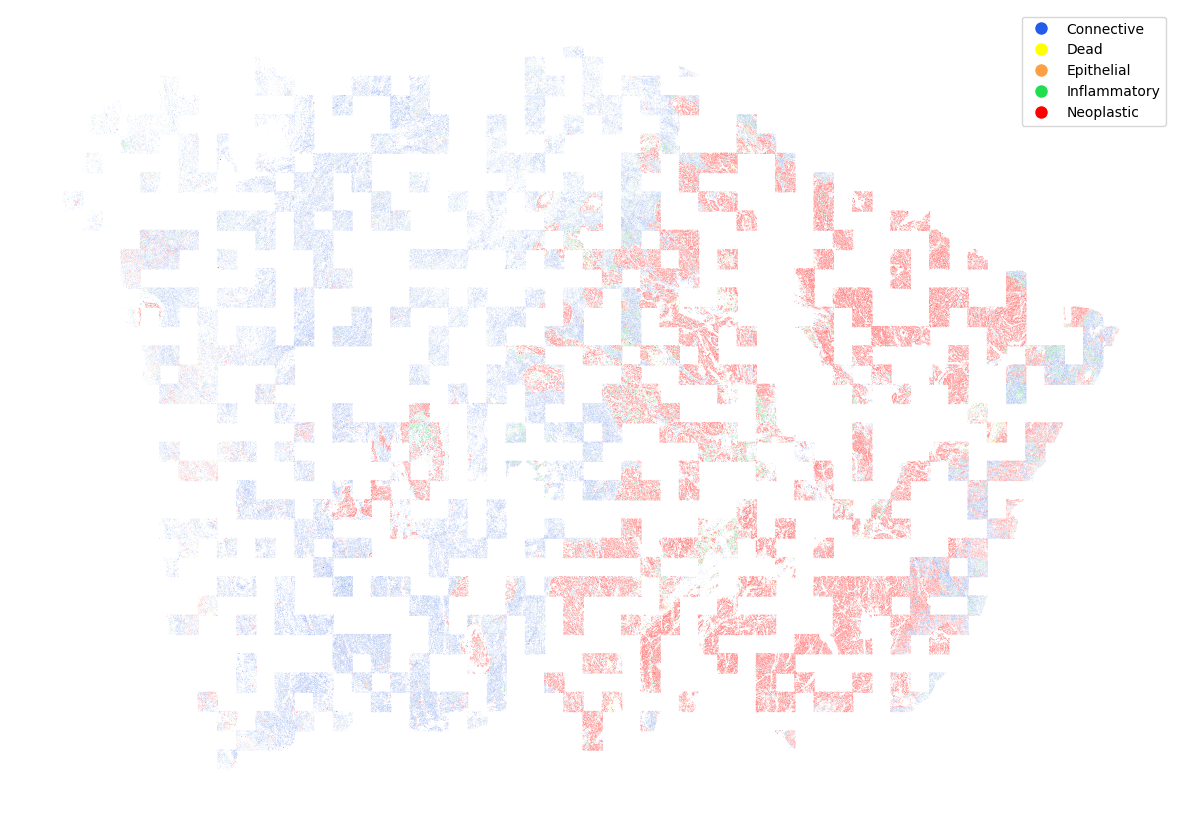

In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

color_dict = {
    "Connective": "#235cec",
    "Dead": "#feff00",
    "Epithelial": "#ff9f44",
    "Inflammatory": "#22dd4d",
    "Neoplastic": "#ff0000",
}
legend_name_dict = {
    "Connective": "Connective",
    "Dead": "Dead",
    "Epithelial": "Epithelial",
    "Inflammatory": "Inflammatory",
    "Neoplastic": "Neoplastic",
}

fig, ax = plt.subplots(figsize=(15, 15))
for class_name, color in color_dict.items():
    subset = cells.gdf[cells.gdf['class_name'] == class_name]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=color,
            label=legend_name_dict[class_name]
        )
plt.gca().invert_yaxis()
plt.axis("off")

# 手动构造带圆点的 legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=legend_name_dict[class_name],
           markerfacecolor=color, markersize=10)
    for class_name, color in color_dict.items()
]
plt.legend(handles=legend_elements, fontsize=10, loc="upper right")

plt.show()

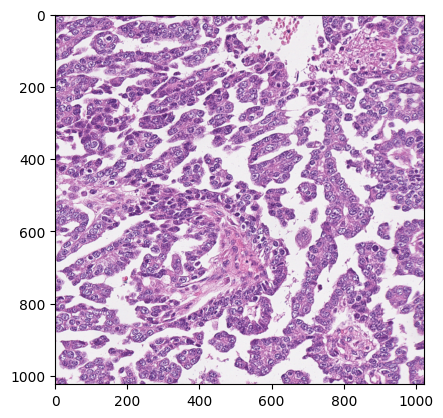

In [ ]:
patch_id = 200
slide_path = "/home/stat-caolei/code/MIA/data/wsi_ov/PKG_OV_Bevacizumab_response/e2/1935769C-Y.svs"

cell_summary = pd.read_csv("output/features/1802840A-Y/features_1802840A-Y_20250609_195150.csv")
patch_summary = cell_summary[cell_summary['patch_id'] == patch_id]
x_coord = patch_summary['coord_x_patch'].unique()[0]
y_coord = patch_summary['coord_y_patch'].unique()[0]

image = extract_patch_by_location(slide_path, (x_coord, y_coord), (1024, 1024), plot_image=True)

In [41]:
patch_summary

,cell_type,probability,centroid_x_wsi,centroid_y_wsi,centroid_x_patch,centroid_y_patch,coord_x_patch,coord_y_patch,bbox_x1,bbox_y1,...,roundness,convexity,pa_ratio,volume_ratio,contour_std,contour_mean,contour_irregularity,patch_row,patch_col,patch_id
342475,Neoplastic,0.988764,23013.033708,19171.651685,5,3,23008,19168,0,0,...,0.753702,1.033708,12.727908,7.233301,1.351603,3.623446,0.373016,20,24,200
342476,Neoplastic,1.000000,23160.402062,19170.896907,152,2,23008,19168,139,0,...,0.246073,1.051546,22.951627,4.305125,3.753793,7.264137,0.516757,20,24,200
342477,Neoplastic,1.000000,23188.061983,19175.219008,180,7,23008,19168,169,0,...,0.555942,1.074380,15.017328,6.235951,2.580282,6.258964,0.412254,20,24,200
342478,Neoplastic,1.000000,23210.928571,19170.714286,202,2,23008,19168,197,0,...,0.342338,1.303571,25.465689,7.131972,1.732599,3.512825,0.493221,20,24,200
342479,Neoplastic,0.529703,23453.727723,19173.816832,445,5,23008,19168,438,0,...,0.768654,1.044554,14.511737,7.530896,2.051843,5.474430,0.374805,20,24,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343688,Neoplastic,0.883929,23894.160714,20141.446429,886,973,23008,19168,879,969,...,0.508840,1.044643,14.142496,5.763898,1.828049,4.330651,0.422119,20,24,200
343689,Neoplastic,1.000000,23418.739437,20170.922535,410,1002,23008,19168,406,995,...,0.623931,1.063380,14.396012,6.524835,1.868642,4.679645,0.399313,20,24,200
343690,Neoplastic,0.206897,23227.666667,20177.632184,219,1009,23008,19168,215,1004,...,0.605859,1.183908,17.610423,7.668482,1.520916,3.778822,0.402484,20,24,200
343691,Inflammatory,1.000000,23772.700000,20181.992857,764,1013,23008,19168,759,1008,...,0.882296,1.042857,12.979262,7.964750,1.652624,4.507160,0.366666,20,24,200


In [53]:
patch_summary.columns

Index(['cell_type', 'probability', 'centroid_x_wsi', 'centroid_y_wsi',
       'centroid_x_patch', 'centroid_y_patch', 'coord_x_patch',
       'coord_y_patch', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'area',
       'perimeter', 'convex_area', 'equivalent_diameter', 'major_axis_length',
       'minor_axis_length', 'orientation', 'orientation_degree',
       'eccentricity', 'solidity', 'extent', 'major_minor_ratio',
       'aspect_ratio', 'roundness', 'convexity', 'pa_ratio', 'volume_ratio',
       'contour_std', 'contour_mean', 'contour_irregularity', 'patch_row',
       'patch_col', 'patch_id'],
      dtype='object')

In [42]:
patch_summary['cell_type'].value_counts()

cell_type
Neoplastic      793
Inflammatory    355
Connective       70
Name: count, dtype: int64

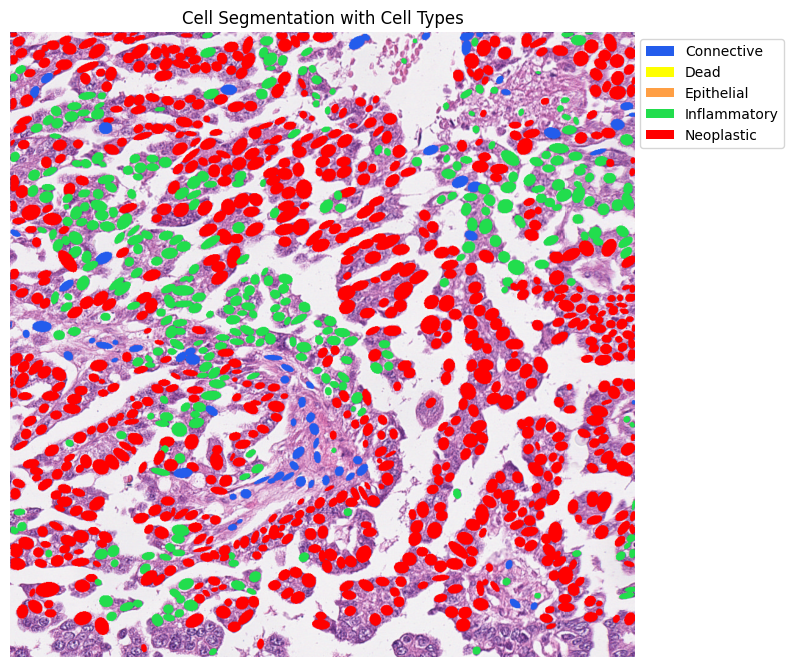

In [44]:
# Reconstruct segmentation with updated colors and legend
import skimage
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Updated color dictionary with hex colors
color_dict = {
    "Connective": "#235cec",
    "Dead": "#feff00", 
    "Epithelial": "#ff9f44",
    "Inflammatory": "#22dd4d",
    "Neoplastic": "#ff0000",
}

# Convert hex colors to RGB for image processing
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]

# Create RGB color dictionary for image pixel assignment
color_dict_rgb = {k: hex_to_rgb(v) for k, v in color_dict.items()}

h, w = 1024, 1024
image = np.array(image)[..., :3]
roi_pred_image = image.copy()

for index, (_, cell) in enumerate(patch_summary.iterrows()):
    y, x = skimage.draw.ellipse(cell['centroid_x_patch'], cell['centroid_y_patch'],
                                cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                #rotation=np.deg2rad(-cell['orientation_degree'])
                                rotation=-cell['orientation'] + np.pi/2)
    c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
    x, y = x[c], y[c]
    roi_pred_image[x, y, :] = color_dict_rgb[cell['cell_type']]

# Create the plot with legend
plt.figure(figsize=(8,8))
plt.imshow(roi_pred_image)

# Create legend using the hex colors
legend_elements = [Patch(facecolor=color, label=cell_type) 
                  for cell_type, color in color_dict.items()]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1))

plt.title('Cell Segmentation with Cell Types')
plt.axis('off')  # Remove axes for cleaner visualization
plt.tight_layout()
plt.savefig("tmp.png")
plt.show()

In [52]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse as sp
import networkx as nx
from torch_geometric.utils.convert import to_networkx

/home/stat-caolei/miniconda3/envs/HEIP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
graph = kneighbors_graph(
    np.array(patch_summary[["centroid_x_patch", "centroid_y_patch"]]),
    n_neighbors=8, mode="distance"
)
# 获取边的信息
I, J, V = sp.find(graph)
edges = list(zip(I, J, 1/V))
edge_index = np.transpose(np.array(edges)[:, 0:2])
pos = np.array(patch_summary.loc[:, ['centroid_x_patch', 'centroid_y_patch']])
cell_types = patch_summary['cell_type']

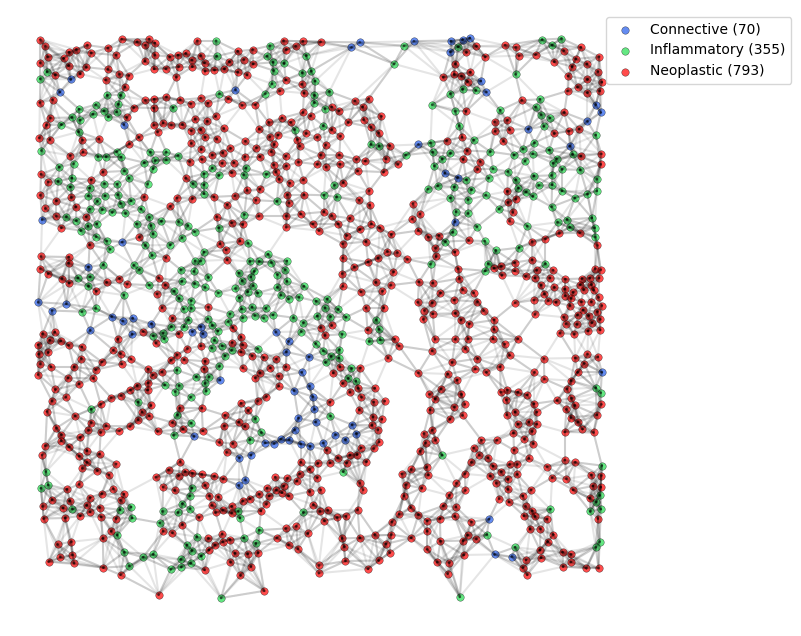

In [59]:
import matplotlib.pyplot as plt


# 使用matplotlib进行可视化
plt.figure(figsize=(8, 8))

color_dict = {
    "Connective": "#235cec",
    "Dead": "#feff00", 
    "Epithelial": "#ff9f44",
    "Inflammatory": "#22dd4d",
    "Neoplastic": "#ff0000",
}

# 使用pos绘制节点
# 为每种类型分别绘制
for cell_type, color in color_dict.items():
    # 找到当前类型的细胞索引
    mask = np.array([ct == cell_type for ct in cell_types])
    
    if np.any(mask):  # 如果存在该类型的细胞
        plt.scatter(pos[mask, 0], pos[mask, 1], 
                    c=color, 
                    label=f'{cell_type} ({np.sum(mask)})', 
                    alpha=0.7, 
                    s=29,
                    edgecolors='black',
                    linewidth=0.3)
#plt.scatter(pos[:, 0], pos[:, 1])
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left')
# 绘制边
for (i, j) in edge_index.T:
    plt.plot([pos[int(i),0], pos[int(j),0]], 
             [pos[int(i),1], pos[int(j),1]], 'k-', alpha=0.1)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [142]:
def get_edge_type(edge, cell_type):
    """
    Args: edge: (in_cell_index, out_cell_index, 1/edge_length)
    """
    mapping = {
        "1-1": 0, "1-2": 1, "1-3": 2, "1-4": 3, "1-5": 4,
        "2-1": 5, "2-2": 6, "2-3": 7, "2-4": 8, "2-5": 9,
        "3-1": 10, "3-2": 11, "3-3": 12, "3-4": 13, "3-5": 14,
        "4-1": 15, "4-2": 16, "4-3": 17, "4-4": 18, "4-5": 19,
        "5-1": 20, "5-2": 21, "5-3": 22, "5-4": 23, "5-5": 24
    }
    return mapping["{}-{}}".format(cell_type[edge[0]], cell_type[edge[1]])]


def get_nuclei_orientation_diff(edge, nuclei_orientation):
    return np.cos(nuclei_orientation[edge[0]] - nuclei_orientation[edge[1]])